## Ziele
Festlegung der Zielgroesse: PCR Platte, spezifisch, wird in kontaminierte Platte (Platte 1) und nicht kontaminierte Platte unterschieden. Ziel ist es mit einem ueberwachtem Lernverfahren vorherzusagen, ob eine Platte kontaminiert sein wird.
Falls das mit annehmbarer Accuracy vorherzusagen ist, interessieren mich vor Allem die Features, die wichtig fuer die Vorhersage sind. Daraus erhoffe ich mir herauszufinden welche Variablen fuer die Kontamination verantwortlich sind / waren. Es handelt sich um eine Klassifikationsaufgabe

In [10]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [2]:
# read data
df = pd.read_csv("../data/output/preprocessed_data.csv",  index_col=0)

In [3]:

# Modify target variable
df = df.assign(
    is_contamined = lambda dataframe: dataframe['PCR_plate'].map(lambda PCR_plate: 1 if PCR_plate == 1 else 0) 
)
df = df.drop(columns=["PCR_plate"])

In [4]:
df.is_contamined

100A    0
100B    1
101A    1
101B    0
103A    0
       ..
S6      1
S60     1
S7      1
S8      1
S9      1
Name: is_contamined, Length: 173, dtype: int64

## Task one split data in test and validation data
Therefore I use a custom function to have balanced classes, as mentioned before my target variable ist if the plate was contaminied

In [6]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print('\n%s:\n---------\ntotal:%d\ntrain_df:%d\ntest_df:%d' % (lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)

    return train_df, test_df

In [8]:
train_df, test_df = split_to_train_test(df, "is_contamined",0.7)


0:
---------
total:90
train_df:63
test_df:27

1:
---------
total:83
train_df:58
test_df:25


In [9]:
# Check Class Balance to select suitable evaluation metric
df.is_contamined.value_counts()

0    90
1    83
Name: is_contamined, dtype: int64

## Task 2: Select a evaluation metric
For my first analyses I will chose the Accuracy as defined: Accuracy = (TP+TN)/(TP+FP+FN+TN) as a metric. It is a well established metric for a two class classification problem and since we have equally balanced classes it is a reasonable choice

## Task 3: Create a baseline model
Since I have a two class classification problem with balanced classes, it is suitable to chose the relative frequency of the more frequent class as naive baseline prediction accuracy.


In [20]:
# baseline estimation
freq_class = max(df.is_contamined.value_counts())
baseline = freq_class / len(df.index)
print("Baseline Estimation ${}".format(baseline))

Baseline Estimation $0.5202312138728323


## Task 4: Use a supervised machine learning model
My goal is mainly to find features 

In [14]:

rf = RandomForestClassifier(n_estimators=100)
fit = rf.fit(train_df.drop(columns=["is_contamined"]), train_df.is_contamined)


In [21]:
# predict
predictions = fit.predict(test_df.drop(columns=["is_contamined"]))

In [22]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
matching = test_df.is_contamined == predictions

In [29]:
list(zip(train_df.drop(columns=["is_contamined"]), rf.feature_importances_))
rf.feature_importances_.sort()

<AxesSubplot:>

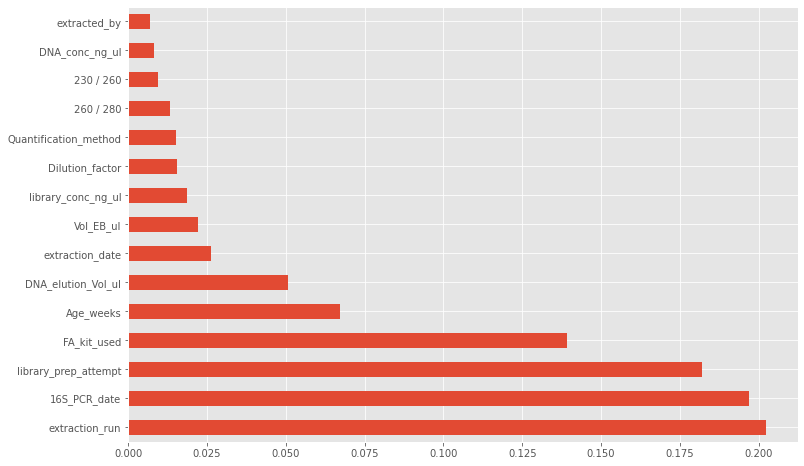

In [33]:
feat_importances = pd.Series(rf.feature_importances_, index=df.drop(columns=["is_contamined"]).columns)
feat_importances.nlargest(15).plot(kind='barh')